In [0]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import os
import glob
import skimage
from torchvision import transforms
import torchvision
from torch import nn
import time
from torchvision.datasets import DatasetFolder

In [0]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    #transforms.RandomResizedCrop((20,20), scale=(0.1, 1.), ratio=(0.5, 2)),
    transforms.CenterCrop(180),
    #transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
    transforms.RandomRotation((20)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
# Взято с https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py, добавлены таргеты
from PIL import Image
def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')      

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

class ImageFolder_with_targ(DatasetFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=default_loader, is_valid_file=None):
        super(ImageFolder_with_targ, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                                   transform=transform,
                                                   target_transform=target_transform,
                                                   is_valid_file=is_valid_file)
        self.imgs = self.samples
        self.root = root
     
    def __getitem__(self, index):
        
        path, target = self.samples[index]
        
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        self.root_new = self.root + '/tsrd/'
        target = int(path.replace(self.root_new, '')[:3])
        return sample, target

    def __len__(self):
        return len(self.samples)

In [0]:
train_data = ImageFolder_with_targ('/content/drive/My Drive/dsign', transform=transformations)

In [0]:
train_data[100][1]

/content/drive/My Drive/dsign/tsrd-train/000_1_0041.png


0

/content/drive/My Drive/dsign/tsrd-train/000_1_0041.png


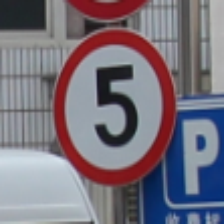

In [0]:
train_data[100][0]

In [0]:
test_data = ImageFolder_with_targ('/content/drive/My Drive/dsign_test', transform=transformations)

In [0]:
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,  drop_last=True)

In [0]:
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False,  drop_last=True)

In [0]:
model = nn.Sequential(nn.Conv2d(1,16,kernel_size = 3),
                      #nn.BatchNorm2d(16),
                      nn.LeakyReLU(),
                      nn.MaxPool2d(2),   
                      nn.Conv2d(16,32,kernel_size = 5),
                      nn.BatchNorm2d(32),
                      nn.LeakyReLU(),
                      nn.MaxPool2d(2),   
                      nn.Conv2d(32,64,kernel_size = 7),
                      #nn.BatchNorm2d(256),
                      nn.LeakyReLU(),
                      nn.MaxPool2d(2),   
                      nn.Conv2d(64,128,kernel_size = 11),
                      nn.BatchNorm2d(128),
                      nn.LeakyReLU(),                     
                      nn.MaxPool2d(2),
                      nn.Flatten(),
                      nn.Linear(2048, 512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 58)
                       )

In [0]:
model = model.to(dev)

In [0]:
X = train_data[0][0].to(dev)
X = X.reshape(1, 1, 180, 180)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 180, 180])
Layer Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)). X shape: torch.Size([1, 16, 178, 178])
Layer LeakyReLU(negative_slope=0.01). X shape: torch.Size([1, 16, 178, 178])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 16, 89, 89])
Layer Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 32, 85, 85])
Layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 32, 85, 85])
Layer LeakyReLU(negative_slope=0.01). X shape: torch.Size([1, 32, 85, 85])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 32, 42, 42])
Layer Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1)). X shape: torch.Size([1, 64, 36, 36])
Layer LeakyReLU(negative_slope=0.01). X shape: torch.Size([1, 64, 36, 36])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Si

In [0]:
def evaluate_accuracy(dataloader_test, model):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in dataloader_test:
        acc_sum += (model(X.to(dev)).argmax(axis=1) == y.to(dev)).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [0]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='mean')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X.to(dev))
            l = loss(y_hat, y.to(dev))
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y.to(dev)).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [0]:
lr, num_epochs = 0.0005, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, dataloader_train, dataloader_test, trainer, num_epochs)

epoch 1, loss 0.0088, train acc 0.971, test acc 0.618, time 24.4 sec
epoch 2, loss 0.0087, train acc 0.968, test acc 0.616, time 24.4 sec
epoch 3, loss 0.0083, train acc 0.971, test acc 0.617, time 24.7 sec
epoch 4, loss 0.0081, train acc 0.975, test acc 0.616, time 24.6 sec
epoch 5, loss 0.0079, train acc 0.975, test acc 0.618, time 24.7 sec
epoch 6, loss 0.0077, train acc 0.974, test acc 0.627, time 24.5 sec
epoch 7, loss 0.0075, train acc 0.976, test acc 0.631, time 24.5 sec
epoch 8, loss 0.0074, train acc 0.977, test acc 0.632, time 25.1 sec
epoch 9, loss 0.0071, train acc 0.979, test acc 0.639, time 24.2 sec
epoch 10, loss 0.0071, train acc 0.980, test acc 0.639, time 24.8 sec


In [0]:
class model_2 (nn.Module):
  def __init__(self, n_clusses):
    super(model_2, self).__init__()

    self.n_clusses = n_clusses
    self.conv1 = nn.Conv2d(1,16,kernel_size = 3)
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.conv11 = nn.Conv2d(1,8,kernel_size = 5)
    torch.nn.init.xavier_uniform_(self.conv1.weight)   
    self.conv2 = nn.Conv2d(16,32,kernel_size = 5)
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.conv3 = nn.Conv2d(32,64,kernel_size = 7)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.conv4 = nn.Conv2d(64,128,kernel_size = 7)
    torch.nn.init.xavier_uniform_(self.conv4.weight)
    self.conv5 = nn.Conv2d(1,8,kernel_size = 1)
    torch.nn.init.xavier_uniform_(self.conv5.weight) 
    self.fc1 = nn.Linear(452496, 512)
    self.fc2 = nn.Linear(512, n_clusses)
    self.activ = nn.LeakyReLU()
    self.flat = nn.Flatten()
    self.pool = nn.MaxPool2d(2)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(128)

  def forward(self, x):

    x_1 = self.conv1(x)
    x_1 = self.activ(x_1)
    x_1 = self.pool(x_1)
    x_2 = self.conv11(x)
    x_2 = self.activ(x_2)
    x_2 = self.pool(x_2)
    x_3 = self.conv5(x)
    x_3 = self.activ(x_3)
    x_11 = self.conv2(x_1)
    x_11 = self.bn1(x_11)
    x_11 = self.activ(x_11)
    x_11 = self.pool(x_11)
    x_11 = self.conv3(x_11)
    x_11 = self.activ(x_11)
    x_11 = self.pool(x_11)  
    x_11 = self.conv4(x_11)
    x_11 = self.bn2(x_11)
    x_11 = self.activ(x_11)
    x_11 = self.pool(x_11)   
    inp = torch.cat((self.flat(x_1), self.flat(x_2), self.flat(x_3), self.flat(x_11)), 1)
    out_ln1 = self.fc1(inp)  
    out = self.fc2(out_ln1) 
    return out

In [0]:
transformations = transforms.Compose([
    transforms.Resize((255,255)),
    transforms.Grayscale(),
    #transforms.RandomResizedCrop((20,20), scale=(0.1, 1.), ratio=(0.5, 2)),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
    transforms.RandomRotation((45)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
train_data = ImageFolder_with_targ('/content/drive/My Drive/dsign', transform=transformations)
test_data = ImageFolder_with_targ('/content/drive/My Drive/dsign_test', transform=transformations)

In [0]:
model_2 = model_2(58)
model_2 = model_2.to(dev)

In [0]:
lr, num_epochs = 0.001, 7
trainer = torch.optim.SGD(model_2.parameters(), lr=lr)
train(model_2, dataloader_train, dataloader_test, trainer, num_epochs)

epoch 1, loss 0.0014, train acc 0.997, test acc 0.651, time 33.0 sec
epoch 2, loss 0.0014, train acc 0.997, test acc 0.650, time 32.9 sec
epoch 3, loss 0.0013, train acc 0.998, test acc 0.649, time 33.3 sec
epoch 4, loss 0.0013, train acc 0.997, test acc 0.649, time 32.4 sec
epoch 5, loss 0.0012, train acc 0.999, test acc 0.651, time 34.4 sec
epoch 6, loss 0.0013, train acc 0.997, test acc 0.658, time 33.1 sec
epoch 7, loss 0.0013, train acc 0.998, test acc 0.646, time 32.9 sec


In [0]:
transformations = transforms.Compose([
    transforms.Resize((255,255)),
    #transforms.Grayscale(),
    #transforms.RandomResizedCrop((20,20), scale=(0.1, 1.), ratio=(0.5, 2)),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
    transforms.RandomRotation((30)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
train_data = ImageFolder_with_targ('/content/drive/My Drive/dsign', transform=transformations)
test_data = ImageFolder_with_targ('/content/drive/My Drive/dsign_test', transform=transformations)

In [0]:
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True,  drop_last=True)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False,  drop_last=True)

In [0]:
from torchvision import  models
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#model_ft.conv1.in_channels=1
model_ft.fc = nn.Linear(num_ftrs, 58)

model_ft = model_ft.to(dev)

In [0]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
lr, num_epochs = 0.01, 30
model_ft.requires_grad_=False
model_ft.layer4.requires_grad_=True
model_ft.layer3.requires_grad_=True
trainer = torch.optim.SGD(model_ft.parameters(), lr=lr)
train(model_ft, dataloader_train, dataloader_test, trainer, num_epochs)

epoch 1, loss 0.0095, train acc 0.470, test acc 0.151, time 35.4 sec
epoch 2, loss 0.0073, train acc 0.628, test acc 0.201, time 35.1 sec
epoch 3, loss 0.0059, train acc 0.702, test acc 0.247, time 35.2 sec
epoch 4, loss 0.0049, train acc 0.746, test acc 0.275, time 35.2 sec


In [0]:
model_ft.layer4.requires_grad_=False